Bending Beam PyMAPDL tutorial
=============================
First we need to do some imports and launch a MAPDL instance by calling launch_mapdl().
The return value is an object used to access this instance via methods. With print() we can check, if everything
is ok. It should print out the used ANSYS product name, MAPDL version and PyMAPDL version.

In [1]:
import numpy as np
from ansys.mapdl.core import launch_mapdl
from bending_beam import Beam, reset_mapdl, create_geometry_v1, \
    beam_summary_string, plot_geometry, plot_results, set_material, set_boundary_conditions_v1

mapdl = launch_mapdl()
print(mapdl)  # show ANSYS version and PyMAPDL version

Product:         ANSYS Academic Research
MAPDL Version:   RELEASE  Release 19.1      BUILD 19.1      UPDATE 20180418
PyMAPDL Version: 0.58.9



As you can see, we imported a lot from bending_beam for this tutorial. bending_beam.py contains all the data for
the beam, and methods to set up and run ANSYS MAPDL, and to generate some images of the beam geometry and
simulation results.

Lets look what data is stored inside Beam:

In [2]:
from IPython.display import Markdown as md
md(beam_summary_string())

$h = 2$ m  <br>
$w = 10$ m <br>
$E = 71000000000.0$ Pa <br>  $\nu = 0.3$

Lets change these values.

In [3]:
Beam.h = 1
Beam.w = 5
Beam.E = 65e9
md(beam_summary_string())

$h = 1$ m  <br>
$w = 5$ m <br>
$E = 65000000000.0$ Pa <br>  $\nu = 0.3$

Now its time to start giving commands to MAPDL. Fist we create the geometry and define an element type
 to use for the beam and set material data E und PR (Poisson ratio).

In [4]:
mapdl.prep7()  # enter preprocessor, which is used to define model
mapdl.blc4(xcorner=0, ycorner=0, width=Beam.w, height=Beam.h)  # creates keypoints, lines, area but not nodes
mapdl.esize(size=min(Beam.w/Beam.segments, Beam.h/2))  # height/2 -> at least two segments along height
mapdl.et(itype=Beam.et_num, ename=Beam.et)  # set element type
mapdl.mat(Beam.mat_num)
mapdl.amesh("all")

'GENERATE NODES AND ELEMENTS   IN  ALL  SELECTED AREAS\n    ** AREA     1 MESHED WITH      20 QUADRILATERALS,        0 TRIANGLES **\n\n NUMBER OF AREAS MESHED     =          1\n MAXIMUM NODE NUMBER        =         85\n MAXIMUM ELEMENT NUMBER     =         20'

MAPDL has so-called processors for different tasks. Not all commands are valid in all processors. Creating the
geometry and setting the material data is done in prep7. To create a rectangle, we can use the command blc4.
To mesh the rectangle we divide the sides in several parts with 'esize()'. Before meshing the rectangle are,
its a good idea to define the element type and set the material number.

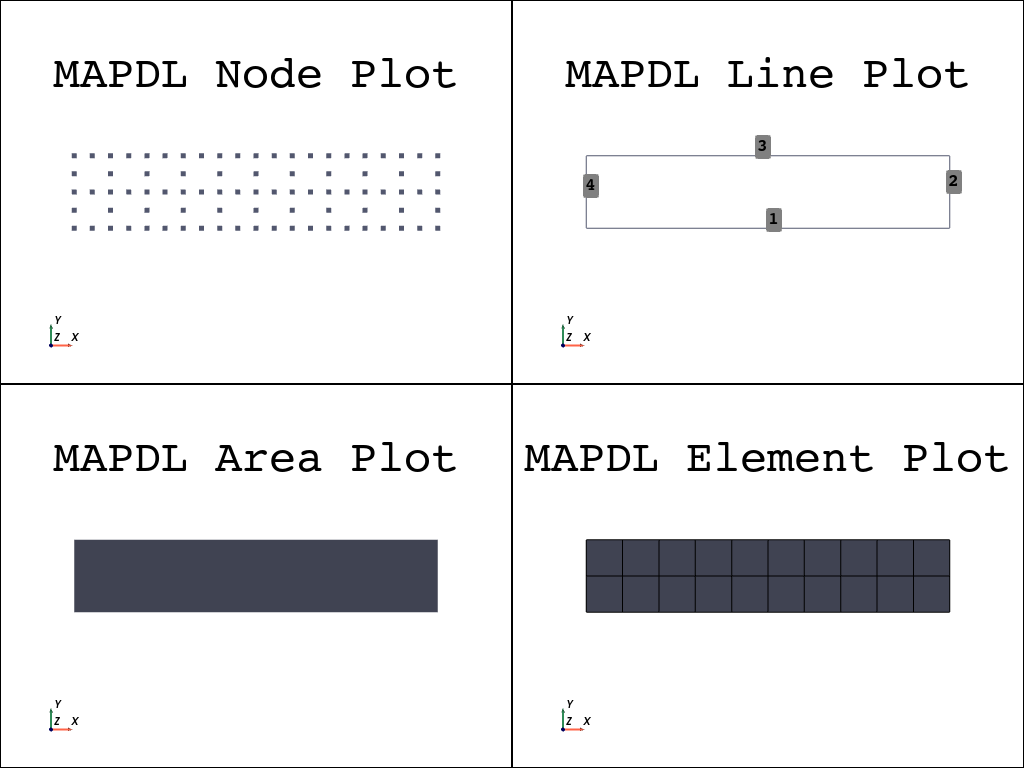

In [5]:
plot_geometry(mapdl)

Next we set the material data with mp()

In [6]:
mapdl.mp("ex", mat=Beam.mat_num, c0=Beam.E)
mapdl.mp("nuxy", Beam.mat_num, c0=Beam.pr)

'MATERIAL          1     NUXY =  0.3000000'

... and the boundary conditions

In [7]:
mapdl.nsel(item="loc", comp="x", vmin=0)
mapdl.d("all", "all")  # fix the left side

mapdl.nsel(item="loc", comp="x", vmin=Beam.w)
mapdl.nsel("r", item="loc", comp="y", vmin=0)  # select bottom right node
mapdl.f("all", "fy", 1e4)  # and apply force in y-direction


mapdl.antype("static")

'PERFORM A STATIC ANALYSIS\n  THIS WILL BE A NEW ANALYSIS'

In [8]:
mapdl.slashsolu()
mapdl.antype("static")
log = mapdl.solve()

... and plot some results

d:\myansys\pymapdl_tutorial\venv\lib\site-packages\pyvista\plotting\plotting.py:2715: UserWarning: Interactive scalar bars disabled for multi-renderer plots
  warnings.warn('Interactive scalar bars disabled for multi-renderer plots')


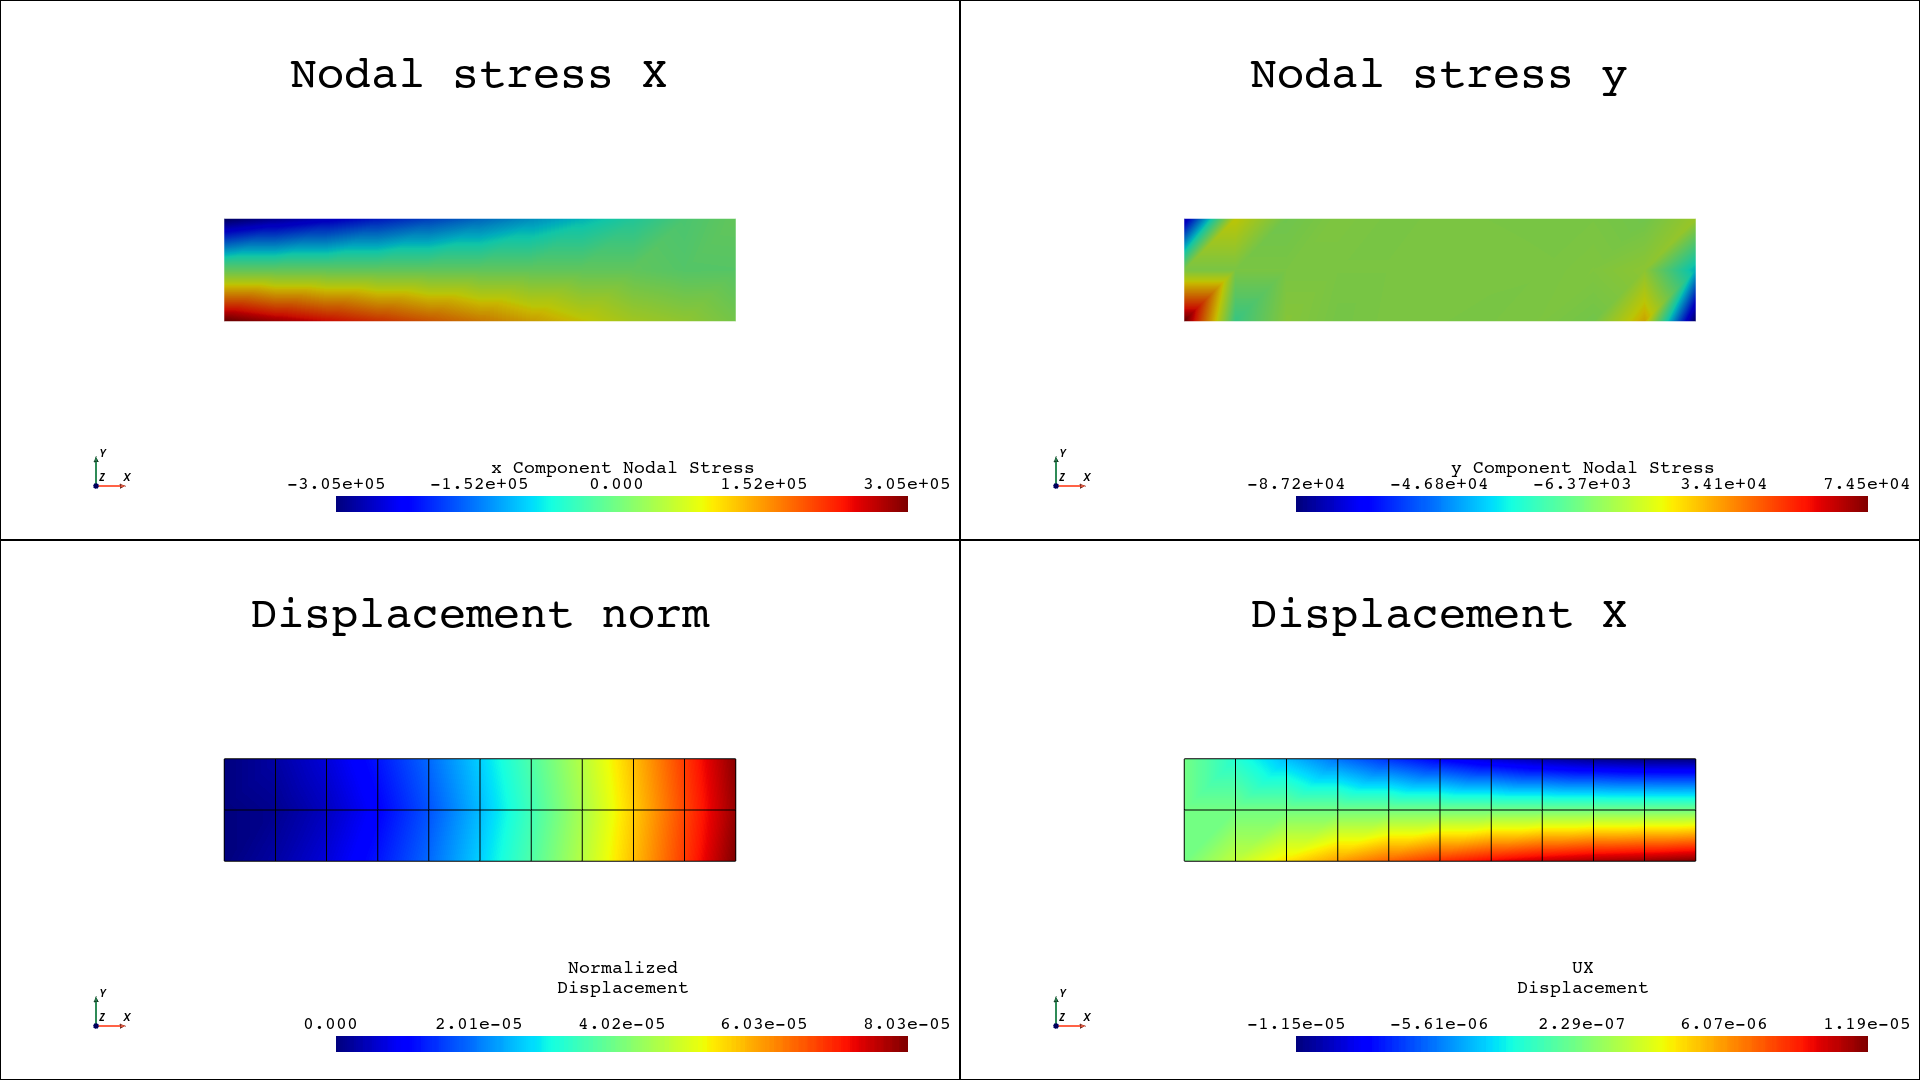

In [9]:
plot_results(mapdl)

Looks like there is not much deformation. Considering we created a beam with 5 m length, 1 m width and
E=65 GPa, that's not surprising. Lets increase the force. Instead of writing all the mapdl-commands again,
we can use the methods from bending_beam.py.

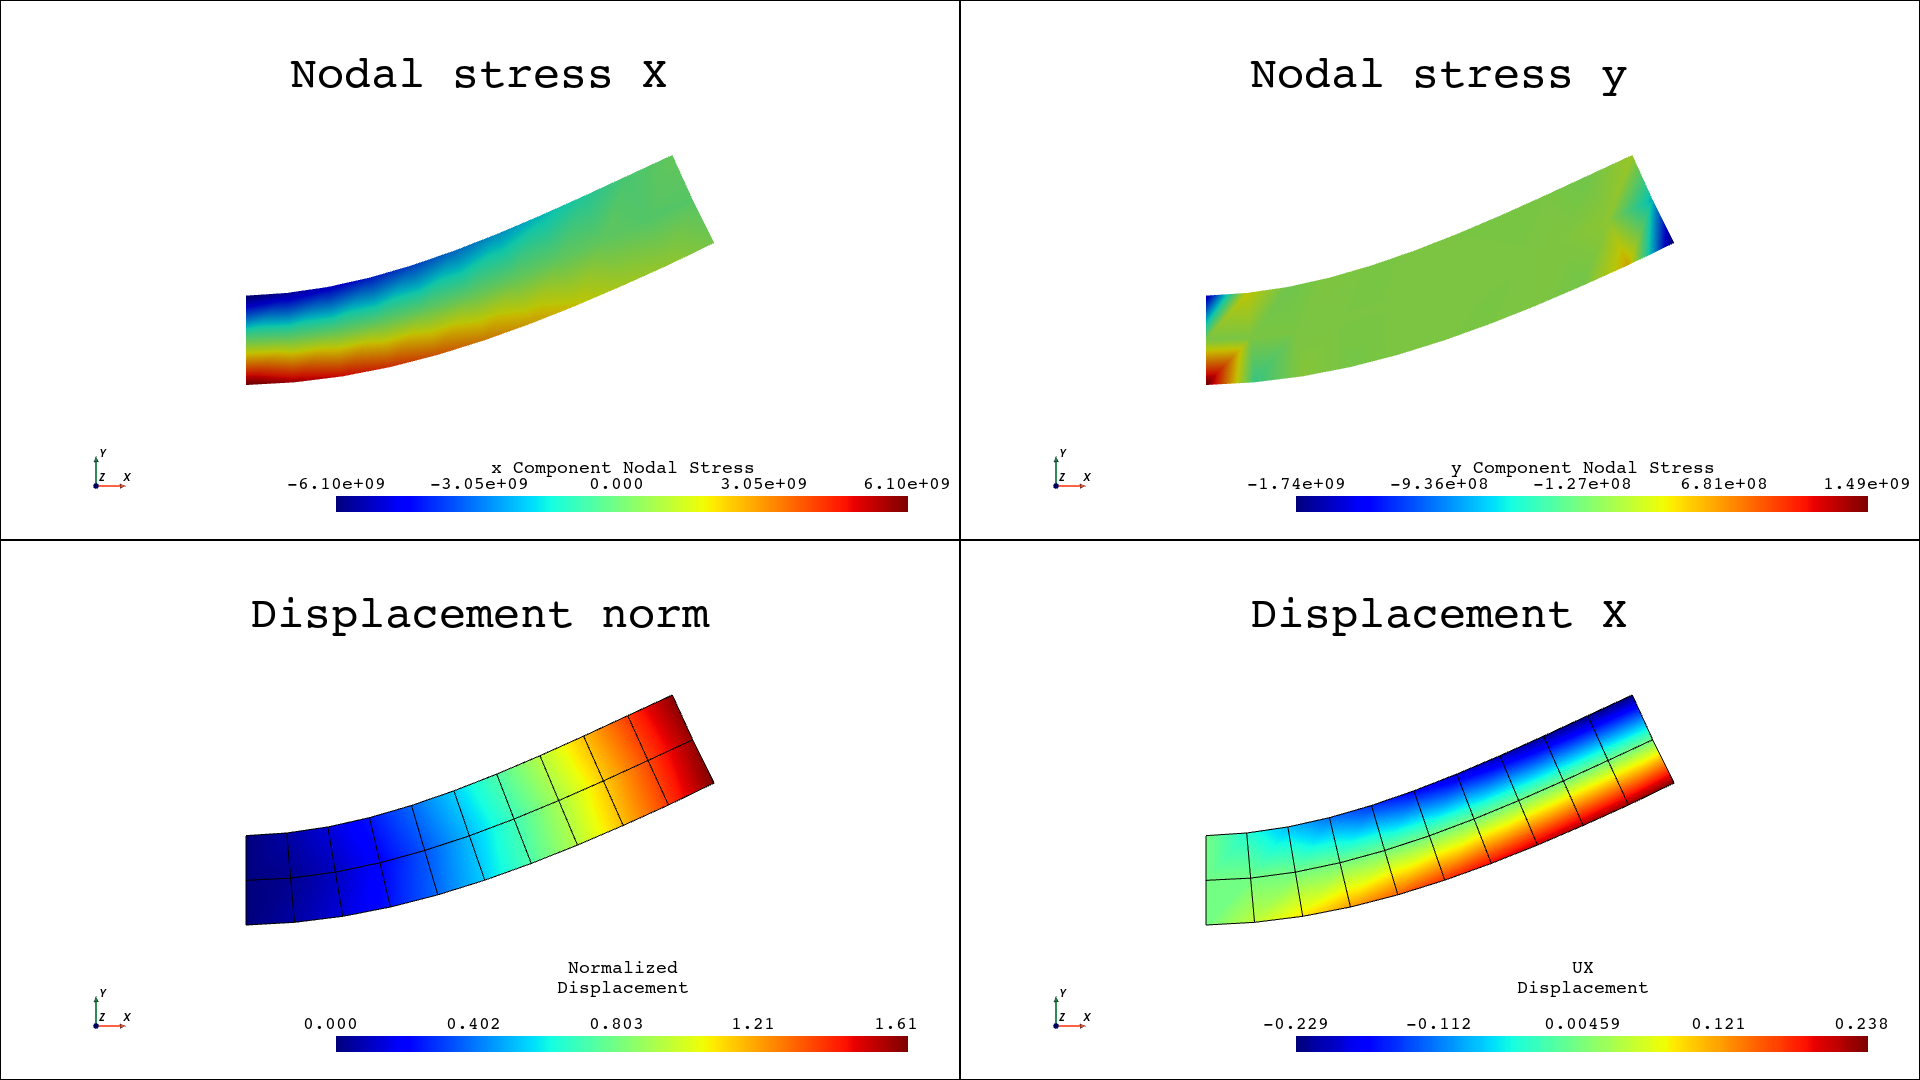

In [10]:
# clear any potential data from previous FEA, and set element type and material data
reset_mapdl(mapdl)
# create geometry for beam
create_geometry_v1(mapdl)  # crash for segments > 77
# set E and Poisson ratio
set_material(mapdl)
# set bounding conditions
set_boundary_conditions_v1(mapdl, force=2e8)

mapdl.slashsolu()
mapdl.antype("static")
mapdl.solve()

plot_results(mapdl)

What about the mesh? Would we get a different result, if we used a finer mesh?

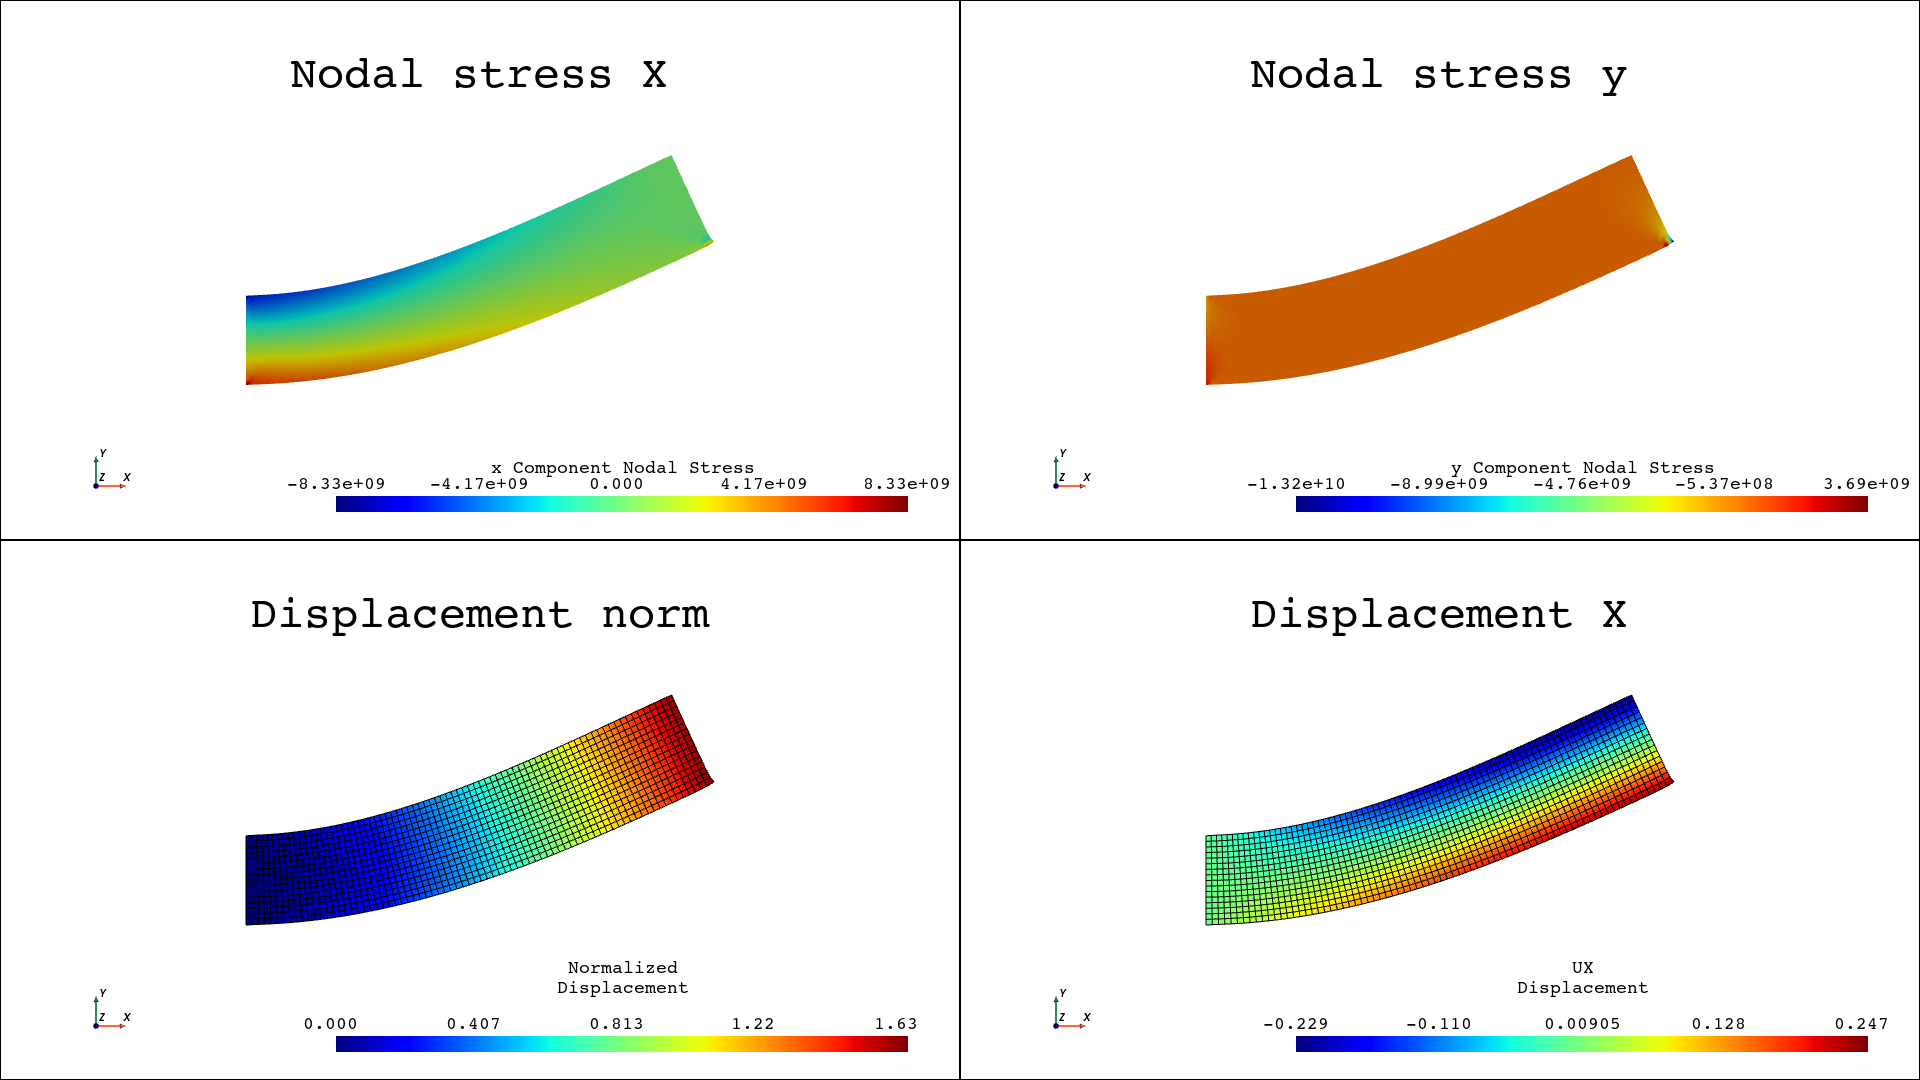

In [11]:
reset_mapdl(mapdl)
create_geometry_v1(mapdl, segments=77)  # crash for segments > 77
set_material(mapdl)
set_boundary_conditions_v1(mapdl, force=2e8)

mapdl.slashsolu()
mapdl.antype("static")
mapdl.solve()

plot_results(mapdl)